### Introduction
Drug-target interaction (DTI) measures the binding of drug molecules to protein targets. Accurate identification of DTI is fundamental for drug discovery and supports many downstream tasks. Among others, drug screening and drug repurposing are two main applications based on DTI:

   - Drug Screening: Helps identify ligand candidates that can bind to the protein of interest.
   - Drug Repurposing: Finds new therapeutic purposes for existing drugs.
    
[DeepPurpose](https://deeppurpose.readthedocs.io/en/latest/) is a PyTorch-based deep learning framework designed to provide a simple yet powerful toolkit for drug-target interaction prediction and its related applications. While many exciting recent works exist in this direction, leveraging these models often requires significant effort due to complex instructions and interfaces. DeepPurpose simplifies this process using a unified framework.

### Encoder-Decoder Architecture

DeepPurpose employs an encoder-decoder framework:

   - Encoders: Convert raw input data (drug SMILES strings and protein amino acid sequences) into learned feature representations.
   - Decoder: Predicts the binding activity score of the drug-target pair based on the encoded features.
    
### Modeling Approach

Drug and Target Representation

   Drug Representation: Simplified Molecular-Input Line-Entry System (SMILES) strings.
   Target Representation: Amino acid sequences of proteins.

#### Encoding Techniques

Various encoding methods can be used for both drugs and targets, allowing flexibility and customization in modeling:

   - Drug Encodings:
      - Extended Connectivity Fingerprints (ECFP), e.g., Morgan fingerprints.
      - Graph-based methods, e.g., ErG, DGL_AttentiveFP.
      - Sequence-based methods, e.g., ESPF.

   - Target Encodings:
      - Amino acid composition, e.g., Conjoint Triad.
      - Sequence-based embeddings, e.g., ESPF.    
      
      
### Model Configuration

The model parameters and architecture can be configured to optimize performance:

   Hidden Dimensions: Layers with sizes like 1024, 512 neurons.
   Training Parameters:
        Epochs: Number of training epochs (e.g., 5 epochs).
        Learning Rate (LR): Step size for optimization algorithms (e.g., 0.001).
        Batch Size: Number of samples per gradient update (e.g., 128).

### Training and Evaluation

The model is trained using a dataset of drug-target pairs with known binding affinities. The data is split into training, validation, and test sets, often in ratios like 70%, 10%, and 20%, respectively.      

### Perform your own training 

- A clean data for model building is provided as valid_data.csv. Use this data to build models and the code is also provided on cell block : Training and test various types of model with different drug and target encoding schemes.

- A test_sample.csv is provided to run predictions on drug target pairs which is on Testing Models block


In [ ]:
!pip install rdkit
!pip install dgl 
!pip install git+https://github.com/bp-kelley/descriptastorus 
!pip install DeepPurpose

The kiba score is basically a affinity value not the original composite kiba score . As it was told to me these are in nano molar ranges then a standard method to convert it use log transformation

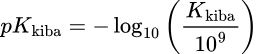

Harmonic mean is used compute Drug target pairs with same pairs but different Kiba score may be due to assay conditions and this computation helps in error reduction.



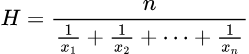

We keep DT pairs where we Filter UniProt_IDs with at least  we have more than 20 pubchem_id i.e compounds.


In [ ]:
import pandas as pd
from scipy.stats import hmean
import numpy as np

_datadf = pd.read_csv("Deloitte_DrugDiscovery_dataset.csv")
filtered_df = _datadf.dropna(subset=['UniProt_ID','pubchem_cid', 'kiba_score'], how='any') 

## Convert kibascore to pKB 
## pKB =−log10​(kibascore in nM​/ 10^9)

def calculate_pKB(nm_value):
    if nm_value > 0:
        return -np.log10(nm_value / 1e9)
    else:
        return np.nan  # Handle non-positive values appropriately
    
def harmonic_mean(series):
  # Filter out NaN values before computing harmonic mean
  series = series.dropna()
  if len(series) > 0:
      return hmean(series)
  else:
      return np.nan    
    
filtered_df['pKB'] = filtered_df['kiba_score'].apply(calculate_pKB)

print(filtered_df.shape)
df_unique = filtered_df.drop_duplicates(subset=['UniProt_ID', 'pubchem_cid', 'pKB'])

df_harmonic = df_unique.groupby(['UniProt_ID', 'pubchem_cid'], as_index=False).agg({'pKB': harmonic_mean})
print(df_harmonic.shape)
_df_final = df_harmonic.drop_duplicates(subset=['UniProt_ID', 'pubchem_cid'])
# Count the number of pubchem_id entries for each UniProt_ID
uniprot_counts = _df_final['UniProt_ID'].value_counts()

# Filter UniProt_IDs with at least 21 pubchem_id entries
valid_uniprot_ids = uniprot_counts[uniprot_counts >= 21].index

# Filter the DataFrame to keep only rows with valid UniProt_IDs
_df_final_filtered = _df_final[_df_final['UniProt_ID'].isin(valid_uniprot_ids)]



#### Get the protein sequences from uniprot API

In [ ]:
import requests

def get_uniprot_sequence(uniprot_id):
  """
  Retrieves the protein sequence for the given UniProt ID.

  Parameters:
      uniprot_id (str): The UniProt ID of the protein.

  Returns:
      str or None: The protein sequence if retrieved successfully, else None.
  """
  url = f'https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta'
  try:
      response = requests.get(url)
      response.raise_for_status()  # Raise an exception for HTTP errors
      fasta_data = response.text
      # Split the FASTA data into header and sequence
      lines = fasta_data.strip().split('\n')
      sequence = ''.join(lines[1:])  # Concatenate all sequence lines
      return sequence
  except requests.exceptions.HTTPError as http_err:
      print(f"HTTP error occurred for UniProt ID {uniprot_id}: {http_err}")
  except Exception as err:
      print(f"An error occurred: {err}")
  return None

# Example usage:
if __name__ == "__main__":
  
  sequences = []
  fail =[]
  unique_ids = _df_final_filtered['UniProt_ID'].unique()
  for ids in unique_ids:
     sequence = get_uniprot_sequence(ids)
     if sequence:
          # Append the result to the list as a dictionary
        sequences.append({'UniProt_ID': ids, 'Sequence': sequence})
        print(f"Sequence retrieved for UniProt ID {ids}")
     else:
        print(f"Could not retrieve sequence for UniProt ID {ids}")
        fail.append({'UniProt_ID': ids, 'Sequence': 'None'})

  df_sequences = pd.DataFrame(sequences) 
  fail_sequence = pd.DataFrame(fail) 
  output_csv_path = 'uniprot_sequences.csv'

  df_sequences.to_csv(output_csv_path, index=False)
  fail_sequence.to_csv("fail_sequences.csv")
  print(f"Sequences saved to '{output_csv_path}'")     

#### Get the pubchem compound smiles 
We generated the file of pubchem cids and use the file to download canonical smiles from pubchem. The PUG REST api wont 
work as there are over \~600K compounds . Access the https://pubchem.ncbi.nlm.nih.gov/ for downloading smiles


<div>
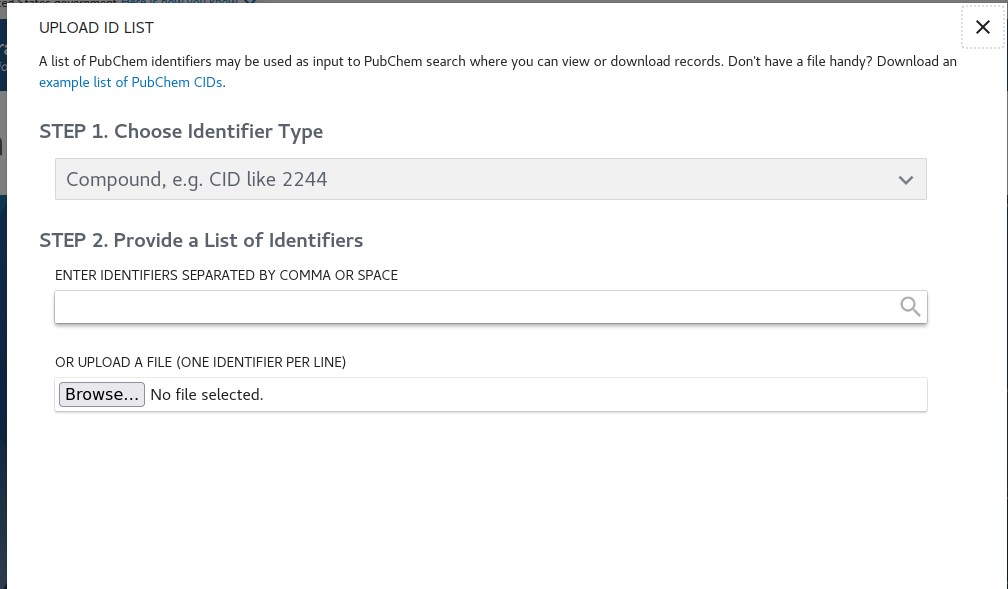
</div

In [ ]:
pubchem_cids = _df_final_filtered['pubchem_cid'].unique()
unique_cids_list = pubchem_cids.tolist()

# Specify the output file name
output_file = "unique_pubchem_cids.txt"

# Write each CID to a new line in the text file
with open(output_file, "w") as file:
  for cid in unique_cids_list:
      file.write(f"{cid}\n")

print(f"Unique PubChem CIDs have been written to {output_file}")

#### Files need to Training and model building
After files are ready three data sets are merged which is uniprot_sequences.csv , unique_puchem_smiles.csv ( downloaded from pubchem) and dataframe _df_final_filtered 
to produce final_data.csv

Next step in checking to see whether the smiles are valid or not and keep the valid smiles along with protein sequences .


Valid Pairs = 903544
Invalid Pairs = 155631

Unavailable smiles is : 136206
available smiles is : 524288

In [13]:
import pandas as pd
from rdkit import Chem

_deloitte_data = pd.read_csv("final_data.csv",index_col=False)

# Lists to store valid and invalid rows
valid_rows = []
invalid_rows = []

# Process each row in the DataFrame
for index, row in _deloitte_data.iterrows():
    smiles = row['canonicalsmiles']
    try:
        # Try to create a molecule from the SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # If successful, add the row to valid_rows
            valid_rows.append(row)
        else:
            # If mol is None, the SMILES is invalid
            invalid_rows.append(row)
    except Exception as e:
        # Catch any exceptions and log the row as invalid
        invalid_rows.append(row)

# Create DataFrames from the valid and invalid rows
df_valid = pd.DataFrame(valid_rows)
df_invalid = pd.DataFrame(invalid_rows)
df_valid.to_csv('valid_smiles_data.csv', index=False)
df_invalid.to_csv('invalid_smiles_data.csv', index=False)

d = df_invalid['pubchem_cid'].unique()
v = df_valid['pubchem_cid'].unique()

print("Available smiles is :" , len(v))
print("Unavailable smiles is :", len(d))


Unavailable smiles is : 136206


#### Use the valid dataframe or file to compute the QED and PkB

/N/soft/rhel8/python/gnu/3.10.5/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


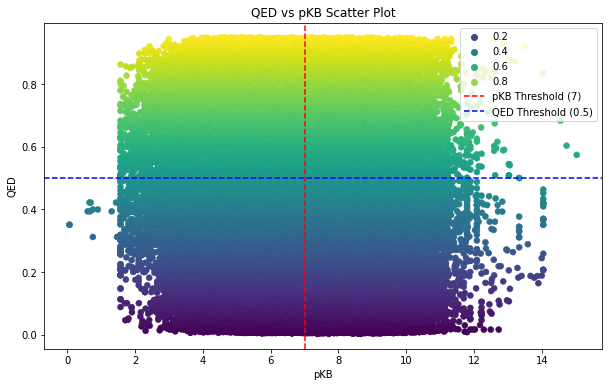

In [21]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate QED
def calculate_qed(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return QED.qed(mol)
    else:
        return None

# Apply the function to calculate QED
df_valid['QED'] = df_valid['canonicalsmiles'].apply(calculate_qed)


# Drop rows with None values (invalid SMILES)
df_valid.dropna(subset=['pKB', 'QED'], inplace=True)

# Define thresholds for drug-likeness
pKB_threshold = 7  # Common threshold for LogP
qed_threshold = 0.5   # Common threshold for QED

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_valid, x='pKB', y='QED', hue='QED', palette='viridis', edgecolor=None)

# Add threshold lines
plt.axvline(pKB_threshold , color='red', linestyle='--', label=f'pKB Threshold ({pKB_threshold})')
plt.axhline(qed_threshold, color='blue', linestyle='--', label=f'QED Threshold ({qed_threshold})')

plt.title('QED vs pKB Scatter Plot')
plt.xlabel('pKB')
plt.ylabel('QED')
plt.legend()
plt.show()

#### Bioactivity Among Targets 
While doing this large scale model its important to keep in mind distribution of active compounds per targets 

What percentage of  targets have how much % of active(>=7) and inactive(<=5) compounds . So once we know then after building this models we can find out by test which targets perform poorly average and best.

In [33]:
## Out of 2278 proteins 

df_valid['Inactive'] = df_valid['pKB'] <= 5

# Group by Uniprot_ID and calculate the percentage of inactives
inactive_percentage = df_valid.groupby('UniProt_ID').apply(
  lambda x: (x['Inactive'].sum() / len(x)) * 100
).reset_index(name='Inactive_Percentage')

# Sort by the percentage of inactives and get the top 10
# Define bins for percentage ranges
bins = [50, 60, 70, 80, 90, 100]
labels = ['50-59%', '60-69%', '70-79%', '80-89%', '90-100%']

# Categorize the inactive percentages into bins
inactive_percentage['Percentage_Range'] = pd.cut(inactive_percentage['Inactive_Percentage'], bins=bins, labels=labels, right=False)

# Count the number of proteins in each percentage range
range_counts = inactive_percentage['Percentage_Range'].value_counts().sort_index()
range_counts

/tmp/ipykernel_4072381/4250181528.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inactive_percentage = df_valid.groupby('UniProt_ID').apply(


Percentage_Range
50-59%     112
60-69%      84
70-79%      63
80-89%      39
90-100%     24
Name: count, dtype: int64

In [40]:
## For active 

df_valid['Active'] = df_valid['pKB'] >= 7 ## 1000nm i.e 1 um

# Group by Uniprot_ID and calculate the percentage of actives
active_percentage = df_valid.groupby('UniProt_ID').apply(
  lambda x: (x['Active'].sum() / len(x)) * 100
).reset_index(name='Active_Percentage')

# Sort by the percentage of inactives and get the top 10
# Define bins for percentage ranges
bins = [50, 60, 70, 80, 90, 100]
labels = ['50-59%', '60-69%', '70-79%', '80-89%', '90-100%']

# Categorize the inactive percentages into bins
active_percentage['Percentage_Range'] = pd.cut(active_percentage['Active_Percentage'], bins=bins, labels=labels, right=False)

# Count the number of proteins in each percentage range
range_counts = active_percentage['Percentage_Range'].value_counts().sort_index()
range_counts

/tmp/ipykernel_4072381/243226718.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inactive_percentage = df_valid.groupby('UniProt_ID').apply(


Percentage_Range
50-59%     207
60-69%     181
70-79%     104
80-89%      60
90-100%     31
Name: count, dtype: int64

#### Training and test various types of model with different drug and target encoding schemes.

Drug Encoding List 

Morgan : Extended-Connectivity Fingerprints \
ESPF : Explainable Substructure Partition Fingerprint \
ERG : 2D pharmacophore descriptions for scaffold hopping \
DGL_AttentiveFP : Attentive FP, Xiong et al. 2020

Target Encoding List 

Conjoint_triad : Conjoint triad features\
ESPF : Explainable Substructure Partition Fingerprint

unique drugs: 524288\
unique target sequence: 2278

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from DeepPurpose import utils, dataset
from scipy.stats import pearsonr
from DeepPurpose import DTI as models
import pandas as pd
from pathlib import Path


class DTIExperiment:
  def __init__(self, X_drugs, X_targets, y, drug_encodings, target_encodings, 
               results_path="DTI_results.csv", model_dir="saved_models"):
      self.X_drugs = X_drugs
      self.X_targets = X_targets
      self.y = y
      self.drug_encodings = drug_encodings
      self.target_encodings = target_encodings
      self.results_path = results_path
      self.model_dir = Path(model_dir)
      self.model_dir.mkdir(parents=True, exist_ok=True)
      self.results = []

  def run(self):
      for drug_encoding in self.drug_encodings:
          for target_encoding in self.target_encodings:
              print(f"Running for: Drug Encoding = {drug_encoding}, Target Encoding = {target_encoding}")
              train, val, test = self.process_data(drug_encoding, target_encoding)
              model = self.configure_model(drug_encoding, target_encoding)
              self.train_model(model, train, val, test)
              metrics = self.evaluate_model(model, train, val, test)
              self.save_results(drug_encoding, target_encoding, metrics)
              self.save_model(model, drug_encoding, target_encoding)
      self.save_results_to_csv()

  def process_data(self, drug_encoding, target_encoding):
      train, val, test = utils.data_process(
          self.X_drugs, self.X_targets, self.y,
          drug_encoding=drug_encoding,
          target_encoding=target_encoding,
          split_method='random',
          frac=[0.7, 0.1, 0.2],
          random_seed=1
      )
      return train, val, test

  def configure_model(self, drug_encoding, target_encoding):
      config = utils.generate_config(
          drug_encoding=drug_encoding,
          target_encoding=target_encoding,
          cls_hidden_dims=[1024, 1024, 512],
          train_epoch=5,
          LR=0.001,
          batch_size=128,
          #transformer_emb_size_drug=128,
          #transformer_emb_size_target=64,
          hidden_dim_drug=128,
          #hidden_dim_protein=64,
          mpnn_hidden_size=128,
          mpnn_depth=3
      )
      model = models.model_initialize(**config)
      return model

  def train_model(self, model, train, val, test):
      model.train(train, val, test)

  def evaluate_model(self, model, train, val, test):
      print("Evaluating model...")
      metrics = {}
      datasets = {'train': train, 'val': val, 'test': test}

      for split, data in datasets.items():
          y_true = data['Label'].values
          y_pred = model.predict(data)
          r2 = r2_score(y_true, y_pred)
          mse = mean_squared_error(y_true, y_pred)
          mae = mean_absolute_error(y_true, y_pred)
          pearson_corr, _ = pearsonr(y_true, y_pred)
          metrics[split] = {
              'r2_score': r2,
              'mse': mse,
              'mae': mae,
              'pearson_corr': pearson_corr
          }
          print(f"{split.capitalize()} Metrics: R2 = {r2:.4f}, MSE = {mse:.4f}, MAE = {mae:.4f}, Pearson Correlation = {pearson_corr:.4f}")

      return metrics

  def save_results(self, drug_encoding, target_encoding, metrics):
      result = {
          'Drug Encoding': drug_encoding,
          'Target Encoding': target_encoding,
          'Train R2': metrics['train']['r2_score'],
          'Val R2': metrics['val']['r2_score'],
          'Test R2': metrics['test']['r2_score'],
          'Train MSE': metrics['train']['mse'],
          'Val MSE': metrics['val']['mse'],
          'Test MSE': metrics['test']['mse'],
          'Train MAE': metrics['train']['mae'],
          'Val MAE': metrics['val']['mae'],
          'Test MAE': metrics['test']['mae'],
          'Train Pearson': metrics['train']['pearson_corr'],
          'Val Pearson': metrics['val']['pearson_corr'],
          'Test Pearson': metrics['test']['pearson_corr'],
      }
      self.results.append(result)

  def save_results_to_csv(self):
      df = pd.DataFrame(self.results)
      df.to_csv(self.results_path, index=False)
      print(f"Results saved to {self.results_path}")

  def save_model(self, model, drug_encoding, target_encoding):
      model_name = f"{drug_encoding}_{target_encoding}_model"
      save_path = self.model_dir / model_name
      model.save_model(save_path)
      print(f"Model saved to {save_path}")


# Example usage:
if __name__ == "__main__":

    
    import pandas as pd

    df_valid = pd.read_csv("valid_data.csv") 
                           
    X_drugs = df_valid['canonicalsmiles'].to_numpy()

    # Convert the 'Sequence' column to a NumPy array
    X_target = df_valid['Sequence'].to_numpy()

    # Convert the 'pKB' column to a NumPy array
    y = df_valid['pKB'].to_numpy()

    # Print the shapes of the arrays to verify
    print(f"X_drugs shape: {X_drugs.shape}")
    print(f"X_target shape: {X_target.shape}")
    print(f"y shape: {y.shape}")   


    #drug_encoding_list = ["ESPF", "Morgan", "ErG", "DGL_AttentiveFP"]
    #target_encoding_list = ["Conjoint_triad", "ESPF"]
    drug_encoding_list = ["Morgan"]
    target_encoding_list = ["ESPF"]                       
  
    experiment = DTIExperiment(
      X_drugs=X_drugs,
      X_targets=X_targets,
      y=y,
      drug_encodings=drug_encoding_list,
      target_encodings=target_encoding_list,
      results_path="DTI_results.csv",
      model_dir="saved_models"
    )

    experiment.run()

#### Results of Modeling

We train several variations of drug and target encoding schemes and we observed that with  

DRUG ENCODING: Morgan TARGET ENCODING: ESPF  train r2: 0.800935 test r2: 0.686860 val r2: 0.684729
                    


In [43]:
resutls = pd.read_csv("DTI_results.csv",header=None)
resutls

,0,1,2,3,4,5,6,7,8,9
0,DRUG ENCODING:,ESPF,TARGET ENCODING:,Conjoint_triad,train r2:,0.726535,test r2:,0.596455,val r2:,0.596959
1,DRUG ENCODING:,ESPF,TARGET ENCODING:,ESPF,train r2:,0.756291,test r2:,0.613042,val r2:,0.614497
2,DRUG ENCODING:,Morgan,TARGET ENCODING:,Conjoint_triad,train r2:,0.777874,test r2:,0.652152,val r2:,0.651634
3,DRUG ENCODING:,Morgan,TARGET ENCODING:,ESPF,train r2:,0.800935,test r2:,0.686860,val r2:,0.684729
4,DRUG ENCODING:,ErG,TARGET ENCODING:,Conjoint_triad,train r2:,0.524671,test r2:,0.488437,val r2:,0.489987
5,DRUG ENCODING:,ErG,TARGET ENCODING:,ESPF,train r2:,0.589087,test r2:,0.546871,val r2:,0.547712
6,DRUG ENCODING:,DGL_AttentiveFP,TARGET ENCODING:,Conjoint_triad,train r2:,0.510111,test r2:,0.494348,val r2:,0.494661
7,DRUG ENCODING:,DGL_AttentiveFP,TARGET ENCODING:,ESPF,train r2:,0.529816,test r2:,0.513932,val r2:,0.512121


#### Load Each of the models and show some predictions with user input and datasets ...

In [14]:
from DeepPurpose import utils, dataset
from DeepPurpose import DTI as models
import warnings
warnings.filterwarnings("ignore")

## Load the models 
model1 = models.model_pretrained(path_dir = './saved_models/Morgan_ESPF_model')
model1

In [9]:
import pandas as pd


drug_encoding = 'Morgan'
target_encoding = 'ESPF'

X_drugs = df_valid['canonicalsmiles'].to_numpy()

# Convert the 'Sequence' column to a NumPy array
X_target = df_valid['Sequence'].to_numpy()

# Convert the 'pKB' column to a NumPy array
y = df_valid['pKB'].to_numpy()

## If we onlyy  want train and test
train, val, test = utils.data_process(X_drugs, X_target, y, 
                                            drug_encoding, target_encoding, 
                                            split_method='random',frac=[0.8,0,0.2],
                                            random_seed = 1)

Drug Target Interaction Prediction Mode...
in total: 903544 drug-target pairs
encoding drug...
unique drugs: 495096
encoding protein...
unique target sequence: 2278
splitting dataset...
Done.


predicting...


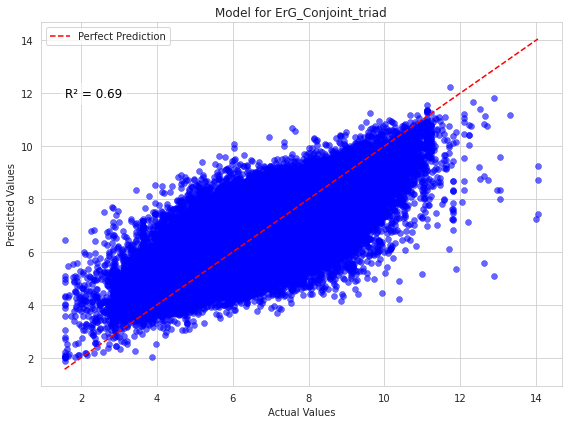

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

y_pred_test = model1.predict(test)
y_test = test['Label'].values
r2 = r2_score(y_test, y_pred_test)

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, color='blue', alpha=0.6, edgecolor=None)

# Plot a line for perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

# Annotate the plot with the R² value
plt.text(min(y_test), max(y_pred_test), f'R² = {r2:.2f}', fontsize=12, verticalalignment='top', horizontalalignment='left', color='black', bbox=dict(facecolor='white', alpha=0.5))

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model for Morgan_ESPF Model')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

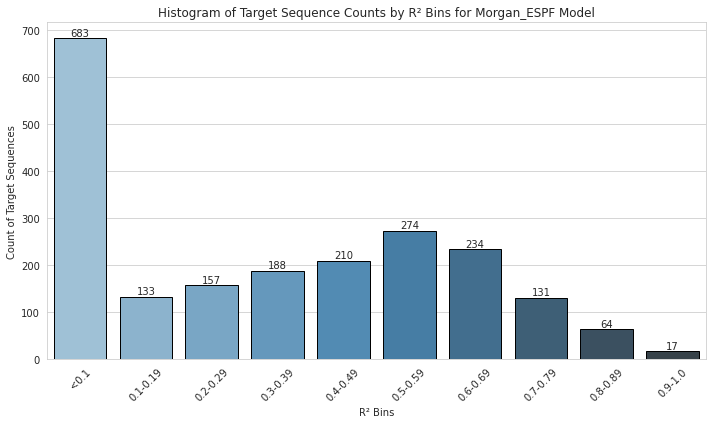

In [11]:


test['Prediction'] = y_pred_test

grouped = test.groupby('Target Sequence')

# Count the number of items in each target sequence
counts = grouped.size().reset_index(name='count')

# Compute R² for each target sequence
def compute_r2(group):
  y_true = group['Label']
  y_pred = group['Prediction']
  return r2_score(y_true, y_pred)

r2_scores = grouped.apply(compute_r2).reset_index(name='R2')

# Merge counts and R² scores
result = pd.merge(counts, r2_scores, on='Target Sequence')

sorted_result = result.sort_values(by='R2', ascending=False)
bins = [-float('inf'), 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['<0.1', '0.1-0.19', '0.2-0.29', '0.3-0.39', '0.4-0.49', '0.5-0.59', '0.6-0.69', '0.7-0.79', '0.8-0.89', '0.9-1.0']

# Categorize R² scores into bins
sorted_result['R2_bin'] = pd.cut(sorted_result['R2'], bins=bins, labels=labels, right=False)

# Count the number of target sequences in each bin
bin_counts = sorted_result['R2_bin'].value_counts().sort_index()

# Set the style
sns.set_style("whitegrid")

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=bin_counts.index, y=bin_counts.values, palette='Blues_d', edgecolor='black')

# Add labels and title
plt.title('Histogram of Target Sequence Counts by R² Bins for Morgan_ESPF Model')
plt.xlabel('R² Bins')
plt.ylabel('Count of Target Sequences')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, count in enumerate(bin_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Testing Models

In [15]:
model1 = models.model_pretrained(path_dir = './saved_models/Morgan_ESPF_model')

#### Testing with Single Drug Target Pair with an example Y value

In [16]:
X_drug = ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']
y = [6.53]
drug_encoding = 'Morgan'
target_encoding = 'ESPF'
X_pred = utils.data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding, 
                                split_method='no_split')
y_pred = model1.predict(X_pred)
print('The predicted score is ' + str(y_pred))

Drug Target Interaction Prediction Mode...
in total: 1 drug-target pairs
encoding drug...
unique drugs: 1
encoding protein...
unique target sequence: 1
splitting dataset...
do not do train/test split on the data for already splitted data
predicting...
The predicted score is [5.881862640380859]


#### Testing with a Sample File of only Drug - Target pairs 

We can then use the virtual_screening function to generate a list of drug-target pairs that have high binding affinities. If no drug/target names are provided, the index of the drug/target list is used instead.


In [119]:
## Test sample file is provided to predict drug - target interaction continuois values
test_file = pd.read_csv("test_sample.csv")
dr = test_file['canonincalsmiles'].to_numpy() 
target = test_file['Sequence'].to_numpy() 
y_pred = models.virtual_screening(dr, target, model1)

virtual screening...
Drug Target Interaction Prediction Mode...
in total: 100 drug-target pairs
encoding drug...
unique drugs: 100
encoding protein...
unique target sequence: 91
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |  Drug 23  |  Target 23  |      9.48     |
|  2   |   Drug 9  |   Target 9  |      9.09     |
|  3   |  Drug 33  |  Target 33  |      9.06     |
|  4   |  Drug 70  |  Target 70  |      8.91     |
|  5   |  Drug 24  |  Target 24  |      8.83     |
|  6   |  Drug 69  |  Target 69  |      8.61     |
|  7   |  Drug 37  |  Target 37  |      8.60     |
|  8   |   Drug 4  |   Target 4  |      8.57     |
|  9   |  Drug 32  |  Target 32  |      8.52     |
|  10  |  Drug 16  |  Target 16  |      8.44     |
checkout ./result/virtual_screening.txt for the whole list

